In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# --- BƯỚC 1: TẠO DỮ LIỆU MACKEY-GLASS (DATA GENERATION) ---
def generate_mackey_glass(length=2000, tau=17, delta_t=10, n=10, beta=0.2, gamma=0.1):
    """
    Tạo chuỗi dữ liệu hỗn loạn Mackey-Glass.
    Tham số:
    - tau: Độ trễ (delay). Tau càng lớn, chuỗi càng hỗn loạn.
    - delta_t: Bước thời gian tích phân.
    """
    history_len = tau * delta_t
    # Khởi tạo chuỗi x với giá trị ngẫu nhiên + một chút nhiễu
    x = np.zeros(length + history_len) + 1.2
    
    # Sử dụng phương pháp Euler để giải phương trình vi phân
    for t in range(history_len, length + history_len - 1):
        # x(t - tau)
        xt_tau = x[t - history_len]
        # dx/dt = beta * x(t-tau) / (1 + x(t-tau)^n) - gamma * x(t)
        dxdt = beta * xt_tau / (1 + xt_tau**n) - gamma * x[t]
        # Cập nhật: x(t+1) = x(t) + dx/dt
        x[t+1] = x[t] + dxdt
    
    # Loại bỏ phần khởi tạo ban đầu (transient) và chuẩn hóa về [-1, 1]
    data = x[history_len:]
    data = np.tanh(data - 1) 
    return data

# --- BƯỚC 2: XÂY DỰNG LỚP RESERVOIR NETWORK (ESN Class) ---
class ReservoirNetwork:
    def __init__(self, n_inputs, n_reservoir, n_outputs, 
                 spectral_radius=0.95, sparsity=0.05, leak_rate=0.3, regularization=1e-6):
        """
        Khởi tạo mạng ESN với các tham số toán học chính xác.
        """
        self.N = n_reservoir
        self.alpha = leak_rate    # Leaking rate (alpha)
        self.lambda_reg = regularization # Ridge regression parameter (beta/lambda)
        
        np.random.seed(42) # Cố định seed để tái lập kết quả
        
        # 1. Khởi tạo W_in (Input Weights): Phân phối đều [-0.5, 0.5]
        self.W_in = (np.random.rand(self.N, n_inputs) - 0.5) * 1.0
        
        # 2. Khởi tạo W (Reservoir Weights): Ma trận thưa thớt
        W_rnd = np.random.rand(self.N, self.N) - 0.5
        # Áp dụng tính thưa thớt (Sparsity)
        mask = np.random.rand(self.N, self.N) > sparsity
        W_rnd[mask] = 0
        
        # 3. Điều chỉnh Bán kính phổ (Spectral Radius Scaling)
        # Tính trị riêng lớn nhất (Eigenvalue) của ma trận W hiện tại
        radius = np.max(np.abs(np.linalg.eigvals(W_rnd)))
        # Scale ma trận W để bán kính phổ bằng đúng spectral_radius mong muốn
        self.W = W_rnd * (spectral_radius / radius)
        
        self.W_out = None # Sẽ được tính khi train
        
    def get_states(self, inputs):
        """
        Thu thập các vector trạng thái x(t) của Reservoir.
        Công thức: x(t) = (1-alpha)*x(t-1) + alpha * tanh(W_in*u(t) + W*x(t-1))
        """
        T = inputs.shape[0]
        states = np.zeros((T, self.N))
        x = np.zeros(self.N) # Trạng thái ban đầu x(0) = 0
        
        for t in range(T):
            u = inputs[t]
            # Tính pre-activation: u_in = W_in * u + W * x_old
            pre_activation = np.dot(self.W_in, u) + np.dot(self.W, x)
            
            # Cập nhật trạng thái (State Update Equation)
            x = (1 - self.alpha) * x + self.alpha * np.tanh(pre_activation)
            
            states[t] = x
            
        return states
    
    def fit(self, inputs, targets, washout=100):
        """
        Huấn luyện W_out bằng Ridge Regression.
        """
        # 1. Thu thập trạng thái
        states = self.get_states(inputs)
        
        # 2. Loại bỏ giai đoạn washout (giai đoạn khởi động chưa ổn định)
        X = states[washout:]       # Kích thước: (T-washout) x N
        Y = targets[washout:]      # Kích thước: (T-washout) x n_outputs
        
        # 3. Giải phương trình nghiệm đóng (Closed-form solution)
        # W_out = (X^T * X + lambda * I)^-1 * X^T * Y
        # Lưu ý: Trong code dùng pseudo-inverse hoặc giải hệ phương trình tuyến tính cho ổn định
        
        # X_T * X
        XtX = np.dot(X.T, X)
        # Cộng thêm ma trận điều chuẩn: lambda * I
        reg_matrix = self.lambda_reg * np.eye(self.N)
        
        # Tính nghịch đảo: (X^T * X + lambda * I)^-1
        inverse_term = np.linalg.inv(XtX + reg_matrix)
        
        # W_out = Inverse * X^T * Y
        self.W_out = np.dot(np.dot(inverse_term, X.T), Y)
        
        # Tính toán lỗi trên tập train (MSE)
        pred_train = np.dot(X, self.W_out)
        mse = np.mean((pred_train - Y)**2)
        print(f"Training MSE: {mse:.6f}")
        
    def predict(self, inputs):
        """
        Dự báo dựa trên input mới (One-step ahead prediction)
        """
        states = self.get_states(inputs)
        return np.dot(states, self.W_out)

    def generate(self, initial_input, n_steps, initial_state=None):
        outputs = np.zeros((n_steps, 1))
        u = initial_input
        # Nếu có trạng thái ban đầu (từ tập train) thì dùng, không thì reset về 0
        x = initial_state if initial_state is not None else np.zeros(self.N)
        
        for t in range(n_steps):
            pre_activation = np.dot(self.W_in, u) + np.dot(self.W, x)
            x = (1 - self.alpha) * x + self.alpha * np.tanh(pre_activation)
            y = np.dot(x, self.W_out)
            outputs[t] = y
            u = y # Loop back
        return outputs

Training MSE: 0.000001
--- KẾT QUẢ DỰ BÁO ---
Near-Future (t + 10):
  Thực tế: -0.5121
  Dự báo : -0.3785
  Sai số : 0.133590

Far-Future (t + 100):
  Thực tế: -0.2043
  Dự báo : -12.9503
  Sai số : 12.746054


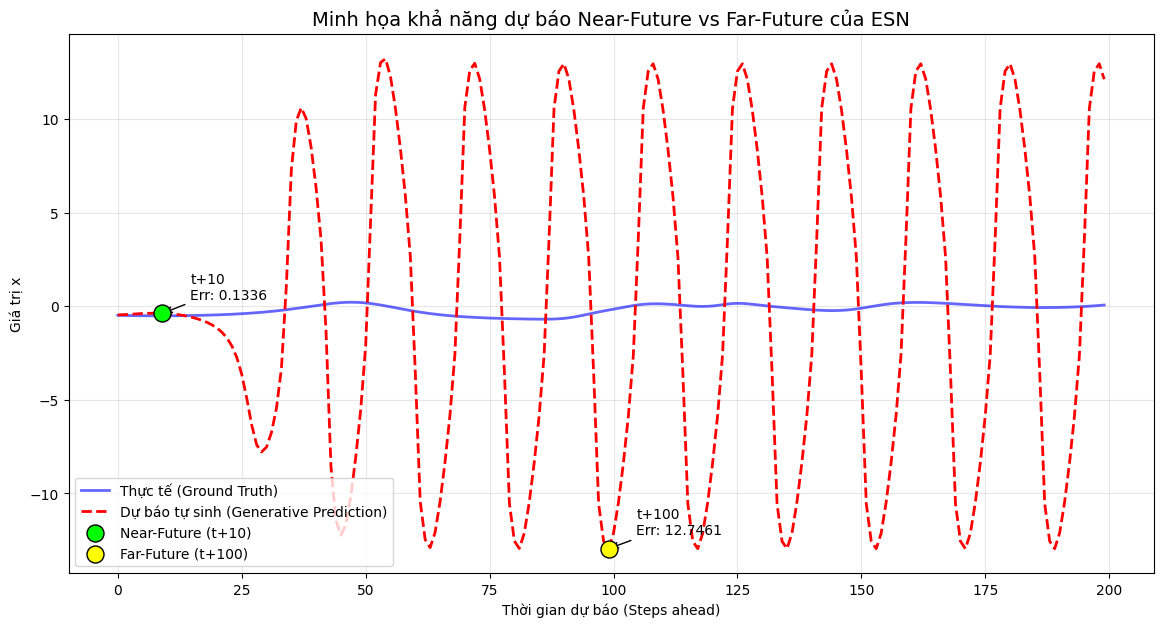

In [ ]:
#--- 2. THỰC HIỆN YÊU CẦU: NEAR & FAR FUTURE PREDICTION ---

# Chuẩn bị dữ liệu
total_len = 3000
data = generate_mackey_glass(length=total_len)
train_len = 2000
test_len = 200 # ta cần ít nhất 100 bước cho Far-future

inputs  = data[:-1].reshape(-1, 1)
targets = data[1:].reshape(-1, 1)

X_train, Y_train = inputs[:train_len], targets[:train_len]
# Tập test thực tế (Ground Truth) để so sánh
ground_truth_test = targets[train_len : train_len + test_len]

# Khởi tạo và Huấn luyện
esn = ReservoirNetwork(n_inputs=1, n_reservoir=500, n_outputs=1, 
                       spectral_radius=0.95, leak_rate=0.4)
esn.fit(X_train, Y_train)

# --- QUAN TRỌNG: Lấy trạng thái cuối cùng của tập train để làm mồi ---
# Điều này giúp dự báo mượt mà liên tục từ train sang test
states_train = esn.get_states(X_train)
last_state = states_train[-1]
last_input = X_train[-1]

# Chạy Generative Mode cho 200 bước
prediction = esn.generate(initial_input=last_input, n_steps=test_len, initial_state=last_state)

# --- 3. PHÂN TÍCH KẾT QUẢ TẠI T+10 VÀ T+100 ---

# Lấy giá trị cụ thể
val_true_10 = ground_truth_test[9]   # Index 9 là bước thứ 10
val_pred_10 = prediction[9]

val_true_100 = ground_truth_test[99] # Index 99 là bước thứ 100
val_pred_100 = prediction[99]

# Tính sai số tuyệt đối
err_10  = np.abs(val_true_10 - val_pred_10)
err_100 = np.abs(val_true_100 - val_pred_100)

print(f"--- KẾT QUẢ DỰ BÁO ---")
print(f"Near-Future (t + 10):")
print(f"  Thực tế: {val_true_10[0]:.4f}")
print(f"  Dự báo : {val_pred_10[0]:.4f}")
print(f"  Sai số : {err_10[0]:.6f}")

print(f"\nFar-Future (t + 100):")
print(f"  Thực tế: {val_true_100[0]:.4f}")
print(f"  Dự báo : {val_pred_100[0]:.4f}")
print(f"  Sai số : {err_100[0]:.6f}")

# --- 4. VẼ ĐỒ THỊ MINH HỌA ---
plt.figure(figsize=(14, 7))

# Vẽ đường dữ liệu
plt.plot(range(test_len), ground_truth_test, 'b-', label='Thực tế (Ground Truth)', alpha=0.6, linewidth=2)
plt.plot(range(test_len), prediction, 'r--', label='Dự báo tự sinh (Generative Prediction)', linewidth=2)

# Đánh dấu điểm t+10
plt.scatter(9, val_pred_10, color='lime', s=150, zorder=5, edgecolors='k', label='Near-Future (t+10)')
plt.annotate(f't+10\nErr: {err_10[0]:.4f}', (9, val_pred_10), xytext=(20, 10), 
             textcoords='offset points', arrowprops=dict(arrowstyle="->"))

# Đánh dấu điểm t+100
plt.scatter(99, val_pred_100, color='yellow', s=150, zorder=5, edgecolors='k', label='Far-Future (t+100)')
plt.annotate(f't+100\nErr: {err_100[0]:.4f}', (99, val_pred_100), xytext=(20, 10), 
             textcoords='offset points', arrowprops=dict(arrowstyle="->"))

plt.title('Minh họa khả năng dự báo Near-Future vs Far-Future của ESN', fontsize=14)
plt.xlabel('Thời gian dự báo (Steps ahead)')
plt.ylabel('Giá trị x')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()